In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

 99% 327M/330M [00:10<00:00, 33.4MB/s]
100% 330M/330M [00:10<00:00, 31.6MB/s]


In [4]:
!unzip face-mask-12k-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dir = "Face Mask Dataset/Train"
valid_dir = "Face Mask Dataset/Validation"
test_dir = "Face Mask Dataset/Test"

train_dataset = ImageFolder(root=train_dir, transform=transform)
valid_dataset = ImageFolder(root=valid_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

In [7]:
class VAE_UNet(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE_UNet, self).__init__()

        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.encoder_conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.encoder_conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)

        self.decoder_tconv1 = nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1)
        self.decoder_tconv1_adjust = nn.Conv2d(512, 256, kernel_size=1)

        self.decoder_tconv2 = nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1)
        self.decoder_tconv3 = nn.ConvTranspose2d(384, 16, kernel_size=4, stride=2, padding=1)
        self.decoder_tconv4 = nn.ConvTranspose2d(144, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_tconv5 = nn.ConvTranspose2d(96, 3, kernel_size=4, stride=2, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

    def encode(self, x):
        x1 = self.relu(self.encoder_conv1(x))
        x2 = self.relu(self.encoder_conv2(x1))
        x3 = self.relu(self.encoder_conv3(x2))
        x4 = self.relu(self.encoder_conv4(x3))
        x5 = self.relu(self.encoder_conv5(x4))

        x5_flat = x5.view(x5.size(0), -1)
        mu = self.fc_mu(x5_flat)
        logvar = self.fc_logvar(x5_flat)
        return mu, logvar, x1, x2, x3, x4, x5

    def decode(self, z, x1, x2, x3, x4, x5):
        z = z.view(z.size(0), -1, 1, 1)

        x6 = self.relu(self.decoder_tconv1(z))
        x5_resized = nn.functional.interpolate(x5, size=x6.size()[2:], mode='bilinear', align_corners=False)
        x5_adjusted = self.relu(self.decoder_tconv1_adjust(x5_resized))
        x6_cat = torch.cat([x6, x5_adjusted], dim=1)
        x7 = self.relu(self.decoder_tconv2(x6_cat))
        x4_resized = nn.functional.interpolate(x4, size=x7.size()[2:], mode='bilinear', align_corners=False)
        x7_cat = torch.cat([x7, x4_resized], dim=1)
        x8 = self.relu(self.decoder_tconv3(x7_cat))
        x3_resized = nn.functional.interpolate(x3, size=x8.size()[2:], mode='bilinear', align_corners=False)
        x8_cat = torch.cat([x8, x3_resized], dim=1)
        x9 = self.relu(self.decoder_tconv4(x8_cat))
        x2_resized = nn.functional.interpolate(x2, size=x9.size()[2:], mode='bilinear', align_corners=False)
        x9_cat = torch.cat([x9, x2_resized], dim=1)
        x10 = self.sigmoid(self.decoder_tconv5(x9_cat))
        return x10

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar, x1, x2, x3, x4, x5 = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, x1, x2, x3, x4, x5)
        return recon_x, mu, logvar

vae = VAE_UNet().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

def vae_loss(recon_x, x, mu, logvar, epoch, epochs):
    BCE = nn.BCELoss(reduction='sum')
    recon_x_resized = F.interpolate(recon_x, size=x.size()[2:], mode='bilinear', align_corners=False)
    recon_loss = BCE(recon_x_resized, x)

    beta = min(1.0, epoch / (0.25 * epochs))
    kl_weight = beta * 0.01
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_divergence

Epoch: 1, Train Loss: 29069.6891, Val Loss: 26825.5346
Epoch: 2, Train Loss: 26511.4346, Val Loss: 26341.1235
Epoch: 3, Train Loss: 26209.7689, Val Loss: 26069.6086
Epoch: 4, Train Loss: 26088.9496, Val Loss: 25971.1382
Epoch: 5, Train Loss: 26021.0097, Val Loss: 25923.6634
Epoch: 6, Train Loss: 25970.5311, Val Loss: 25879.0314
Epoch: 7, Train Loss: 25939.9803, Val Loss: 25859.5173
Epoch: 8, Train Loss: 25908.8473, Val Loss: 25839.4900
Epoch: 9, Train Loss: 25888.5271, Val Loss: 25815.9233
Epoch: 10, Train Loss: 25873.9910, Val Loss: 25794.6876


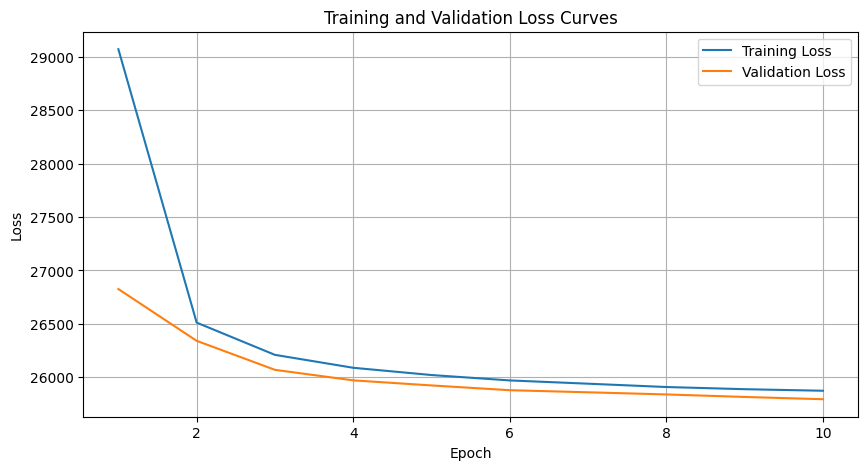

In [8]:
num_epochs = 10

train_losses = []
valid_losses = []

vae.eval()

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar, epoch, num_epochs)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    valid_loss = 0.0
    with torch.no_grad():
        for data, _ in valid_dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = vae(data)
            loss = vae_loss(recon_batch, data, mu, logvar, epoch, num_epochs)
            valid_loss += loss.item()
    valid_loss /= len(valid_dataloader.dataset)
    valid_losses.append(valid_loss)

    print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, train_loss, valid_loss))

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

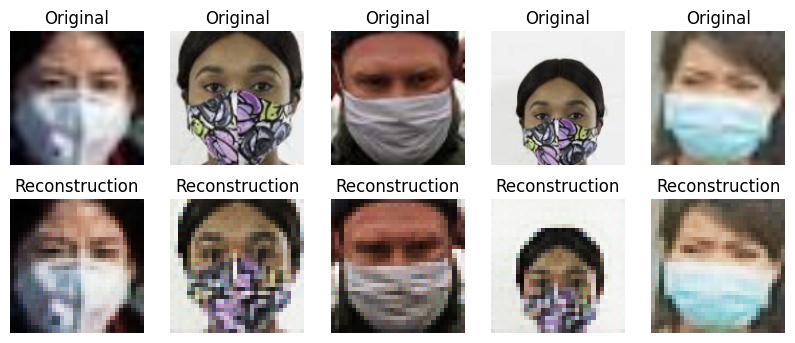

In [9]:
import random

def compare_reconstructions(model, data_loader, num_samples=5):
    with torch.no_grad():
        for i, (images, _) in enumerate(data_loader):
            images = images.to(device)
            recon_images, _, _ = model(images)
            recon_images = recon_images.cpu()

            sample_indices = random.sample(range(len(images)), num_samples)

            plt.figure(figsize=(10, 4))
            for j, index in enumerate(sample_indices):
                plt.subplot(2, num_samples, j + 1)
                plt.imshow(np.transpose(images[index].cpu(), (1, 2, 0)))
                plt.title("Original")
                plt.axis('off')

                plt.subplot(2, num_samples, j + 1 + num_samples)
                plt.imshow(np.transpose(recon_images[index], (1, 2, 0)))
                plt.title("Reconstruction")
                plt.axis('off')
            plt.show()
            break

compare_reconstructions(vae, test_dataloader, num_samples=5)

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed = autoencoder(data)
        loss = criterion(reconstructed, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10, Loss: 0.0120
Epoch 2/10, Loss: 0.0026
Epoch 3/10, Loss: 0.0017
Epoch 4/10, Loss: 0.0013
Epoch 5/10, Loss: 0.0011
Epoch 6/10, Loss: 0.0010
Epoch 7/10, Loss: 0.0009
Epoch 8/10, Loss: 0.0008
Epoch 9/10, Loss: 0.0008
Epoch 10/10, Loss: 0.0007


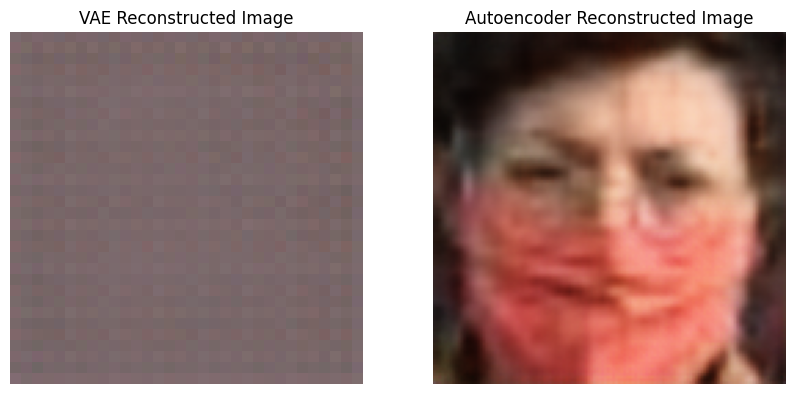

In [11]:
def sample_from_latent_space(vae):
    with torch.no_grad():
        latent_dim = vae.fc_mu.out_features
        random_latent = torch.randn(1, latent_dim).to(device)
        vae.eval()

        x1 = torch.zeros(1, 32, 64, 64).to(device)
        x2 = torch.zeros(1, 64, 32, 32).to(device)
        x3 = torch.zeros(1, 128, 16, 16).to(device)
        x4 = torch.zeros(1, 256, 8, 8).to(device)
        x5 = torch.zeros(1, 512, 4, 4).to(device)
        reconstructed_vae = vae.decode(random_latent, x1, x2, x3, x4, x5)

    return reconstructed_vae

def reconstruct_autoencoder(autoencoder, data):
    with torch.no_grad():
        autoencoder.eval()
        reconstructed_autoencoder = autoencoder(data)
    return reconstructed_autoencoder


def to_numpy_image(tensor):
    return tensor.cpu().detach().numpy().transpose(0, 2, 3, 1)

sampled_image_vae = sample_from_latent_space(vae)
sampled_image_vae_np = np.clip(to_numpy_image(sampled_image_vae), 0, 1)

for batch_idx, (data, _) in enumerate(test_dataloader):
    data = data.to(device)
    reconstructed_autoencoder = reconstruct_autoencoder(autoencoder, data)
    break

reconstructed_autoencoder_np = np.clip(to_numpy_image(reconstructed_autoencoder), 0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('VAE Reconstructed Image')
plt.imshow(sampled_image_vae_np.squeeze())
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Autoencoder Reconstructed Image')
if reconstructed_autoencoder_np.shape[0] == 1:
    plt.imshow(reconstructed_autoencoder_np.squeeze())
else:
    plt.imshow(reconstructed_autoencoder_np[0].squeeze())
plt.axis('off')
plt.show()

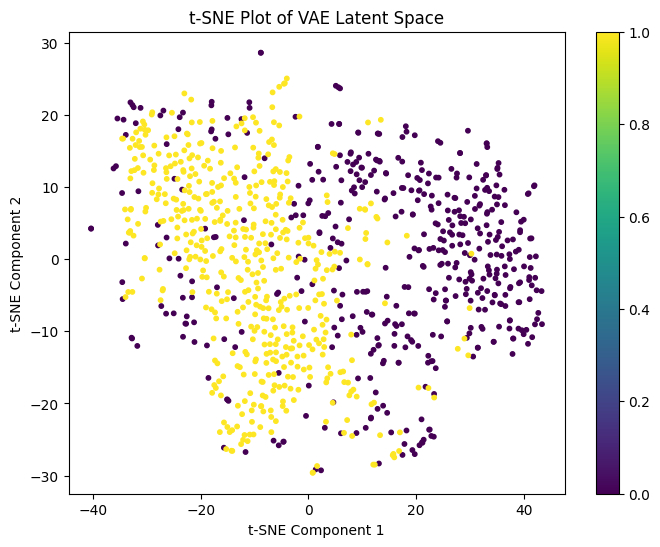

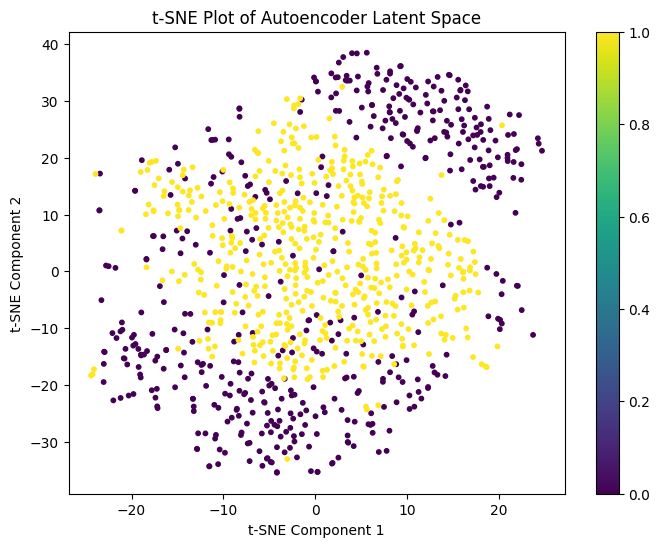

In [12]:
def get_vae_latent_space(vae, data_loader):
    vae.eval()
    latent_space = []
    labels = []
    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device)
            _, _, _, _, _, _, z = vae.encode(images)
            latent_space.append(z.view(z.size(0), -1).cpu().numpy())
            labels.append(labels_batch.numpy())
    latent_space = np.concatenate(latent_space, axis=0)
    labels = np.concatenate(labels)
    return latent_space, labels

def get_autoencoder_latent_space(autoencoder, data_loader):
    autoencoder.eval()
    latent_space = []
    labels = []
    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device)
            encoded = autoencoder.encoder(images)
            latent_space.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            labels.append(labels_batch.numpy())
    latent_space = np.concatenate(latent_space, axis=0)
    labels = np.concatenate(labels)
    return latent_space, labels

def plot_tsne(latent_space, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    latent_space_2d = tsne.fit_transform(latent_space)
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=labels, cmap='viridis', s=10)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

vae_latent_space, vae_labels = get_vae_latent_space(vae, test_dataloader)

autoencoder_latent_space, autoencoder_labels = get_autoencoder_latent_space(autoencoder, test_dataloader)

plot_tsne(vae_latent_space, vae_labels, title='t-SNE Plot of VAE Latent Space')
plot_tsne(autoencoder_latent_space, autoencoder_labels, title='t-SNE Plot of Autoencoder Latent Space')


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

vae_latent_space, vae_labels = get_vae_latent_space(vae, train_dataloader)
autoencoder_latent_space, autoencoder_labels = get_autoencoder_latent_space(autoencoder, train_dataloader)

clf_vae = LogisticRegression(max_iter=2000).fit(vae_latent_space, vae_labels)
clf_autoencoder = LogisticRegression(max_iter=2000).fit(autoencoder_latent_space, autoencoder_labels)

def evaluate_classifier(clf, latent_space, labels):
    predictions = clf.predict(latent_space)
    accuracy = accuracy_score(labels, predictions)
    return accuracy

vae_test_latent_space, vae_test_labels = get_vae_latent_space(vae, test_dataloader)
autoencoder_test_latent_space, autoencoder_test_labels = get_autoencoder_latent_space(autoencoder, test_dataloader)

vae_accuracy = evaluate_classifier(clf_vae, vae_test_latent_space, vae_test_labels)
autoencoder_accuracy = evaluate_classifier(clf_autoencoder, autoencoder_test_latent_space, autoencoder_test_labels)

print("Accuracy of VAE latent representation classifier:", vae_accuracy)
print("Accuracy of Autoencoder latent representation classifier:", autoencoder_accuracy)

Accuracy of VAE latent representation classifier: 0.9485887096774194
Accuracy of Autoencoder latent representation classifier: 0.9758064516129032
